In [1]:
import pandas as pd 
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import random
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math

In [2]:
# Import tables
precipitation_galapagos = pd.read_csv("precipitation_galapagos.csv")
climate_bellavista = pd.read_csv("climate_bellavista.csv")
climate_puerto_ayora = pd.read_csv("climate_puerto-ayora.csv")
average_galapagos = pd.read_csv("average_galapagos.csv")

/var/folders/d0/48hh0ndj2v59mjry93b9grn00000gn/T/ipykernel_91839/4117160330.py:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  precipitation_galapagos = pd.read_csv("precipitation_galapagos.csv")


In [9]:
average_galapagos['observation_date'] = average_galapagos['Date']

In [3]:
def date_to_decimal_year(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    year = date_obj.year
    day_of_year = date_obj.timetuple().tm_yday
    decimal_year = year + (day_of_year - 1) / 365.0
    decimal_year = round(decimal_year,4) 
    return decimal_year

In [4]:
precipitation_bellavista = climate_bellavista[['observation_date', 'precipitation']]
precipitation_ayora = climate_puerto_ayora[['observation_date', 'precipitation']]

In [7]:
new_era_bellavista = precipitation_bellavista[(precipitation_bellavista['observation_date'] >= '2000-06-01') & (precipitation_bellavista['observation_date'] < '2014-05-28')]
new_era_ayora = precipitation_ayora[precipitation_ayora['observation_date'] >= '2000-06-01']
new_era_galapagos = precipitation_galapagos[precipitation_galapagos['Date'] < '2014-05-28']

In [60]:
# For indiviual volcanoes
locations = {'Wolf': ('Wolf', 0.0, -91.20), 'Fernandina': ('Fernandina', -0.22, -91.33), 'Sierra Negra': ('Negra, Sierra', -0.83, -91.17), 'Cerro Azul': ('Azul, Cerro', -0.55, -91.24), 'Alcedo': ('Alcedo', -0.26, -91.07), 'Marchena': ('Marchena', 0.35, -90.5), 'Puerto Ayora': ('Puerto Ayora', -0.74, -90.30), 'Bellavista': ('Bellavista', -0.69, -90.33), 'Sierra Negra south coast': ('Negra, Sierra', -1.01, -91.12), 'Sierra Negra south of caldera': ('Negra, Sierra', -0.86, -91.12), 'Sierra Negra north coast': ('Negra, Sierra', -0.65, -91.12)}
pick = 'Fernandina' # enter desired volcano name here
lat_range = .1 # enter desired latitude range
lon_range = .1 # enter desired longitude range

lat = locations[pick][1]
lon = locations[pick][2]

nearby_rain = new_era_galapagos[(abs(lon - new_era_galapagos['Longitude']) <= lon_range) & (abs(lat - new_era_galapagos['Latitude']) <= lat_range)]
dates = np.sort(nearby_rain['Date'].unique())
averages = [[date, nearby_rain['Precipitation'][nearby_rain['Date'] == date].mean()] for date in dates]
average_rain = pd.DataFrame(averages, columns = ['observation_date', 'precipitation_fern'])


In [12]:
#bell_compare = new_era_bellavista.merge(average_rain, on='observation_date', how='inner')
ayora_compare = new_era_ayora.merge(average_galapagos, on='observation_date', how='inner')

In [13]:
print(ayora_compare)

     observation_date  precipitation        Date  Precipitation
0          2000-06-01            1.7  2000-06-01       0.675112
1          2000-06-02            1.7  2000-06-02       0.344920
2          2000-06-03            0.0  2000-06-03       0.069544
3          2000-06-04            0.9  2000-06-04       0.000957
4          2000-06-05            0.0  2000-06-05       0.009161
...               ...            ...         ...            ...
8338       2023-04-26            0.0  2023-04-26       0.120599
8339       2023-04-27            0.0  2023-04-27       0.091686
8340       2023-04-28            0.0  2023-04-28       0.044509
8341       2023-04-29            0.6  2023-04-29       0.415357
8342       2023-04-30            0.1  2023-04-30       0.283895

[8343 rows x 4 columns]


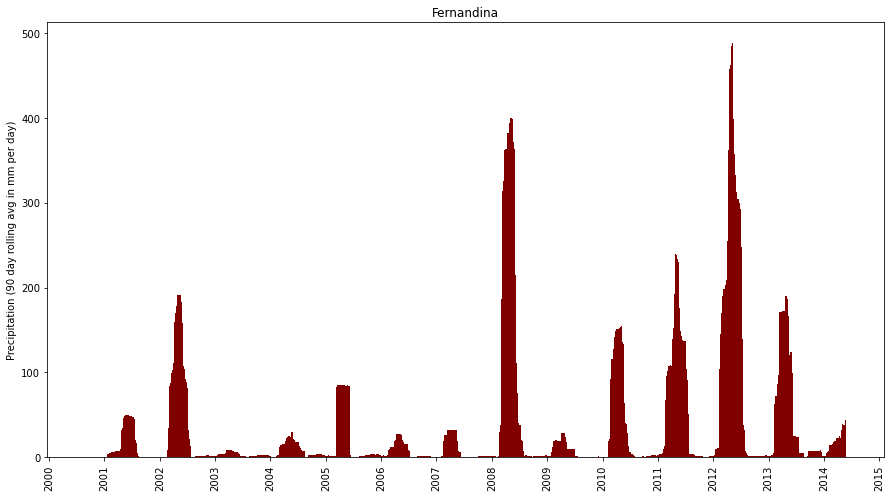

In [88]:
# For 90 day average
sorted_rain = average_rain.sort_values(by=['Date'])
sorted_rain['roll90'] = sorted_rain.Precipitation.rolling(90).sum()
sorted_rain_nona = sorted_rain.dropna()
rolling_fern_nona = np.array(sorted_rain_nona['roll90'])

# Convert date strings to decimal years
decimal_year = np.array(sorted_rain_nona['Date'].apply(date_to_decimal_year))

plt.figure(figsize=(15,8))

plt.bar(decimal_year, rolling_fern_nona, color ='maroon',
       width = 0.01)

plt.ylabel("Precipitation (90 day rolling avg in mm per day)")
 
plt.title('Fernandina')

plt.xticks(ticks=[2000 + i for i in range(16)], rotation=90)

# Data plot
plt.show()

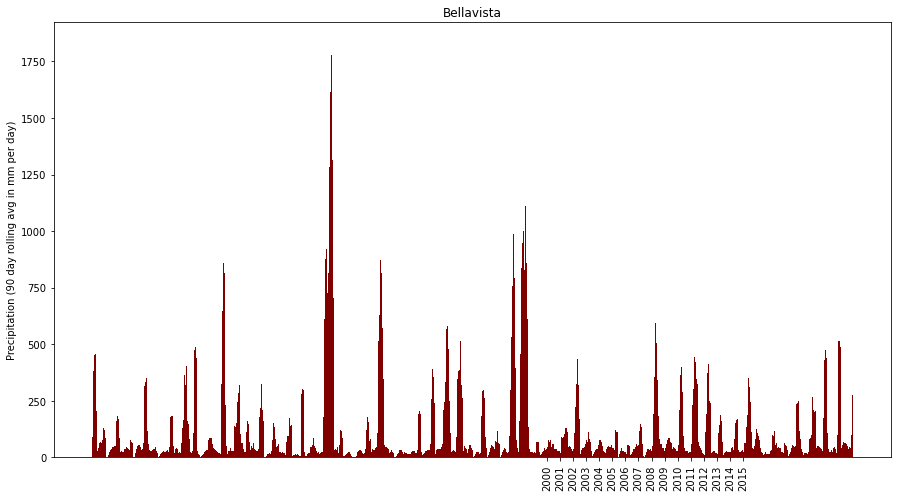

In [6]:
# For 90 day average
sorted_bell = precipitation_ayora.sort_values(by=['observation_date'])
sorted_bell['roll90'] = sorted_bell.precipitation.rolling(90).sum()
sorted_bell_nona = sorted_bell.dropna()
rolling_bell_nona = np.array(sorted_bell_nona['roll90'])

# Convert date strings to decimal years
decimal_year = np.array(sorted_bell_nona['observation_date'].apply(date_to_decimal_year))

plt.figure(figsize=(15,8))

plt.bar(decimal_year, rolling_bell_nona, color ='maroon',
       width = 0.01)

plt.ylabel("Precipitation (90 day rolling avg in mm per day)")
 
plt.title('Bellavista')

plt.xticks(ticks=[2000 + i for i in range(16)], rotation=90)

# Data plot
plt.show()

In [14]:
# Do a regression
bell_sum = ayora_compare['precipitation'].rolling(90).sum().dropna()
fern_sum = ayora_compare['Precipitation'].rolling(90).sum().dropna()

X_constants = sm.add_constant(bell_sum)
model_sm = sm.OLS(fern_sum, X_constants).fit()

r_squared = model_sm.rsquared
print(r_squared)

0.7489502559824147


In [16]:
print(model_sm.params)

const            0.912098
precipitation    0.531768
dtype: float64


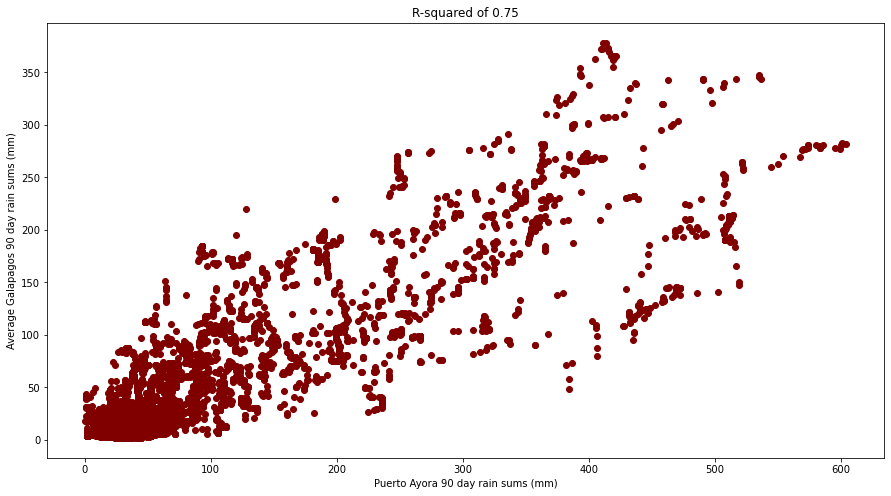

In [17]:
plt.figure(figsize=(15,8))

plt.scatter(bell_sum, fern_sum, color ='maroon')

plt.xlabel("Puerto Ayora 90 day rain sums (mm)") 
plt.ylabel("Average Galapagos 90 day rain sums (mm)") 
plt.title('R-squared of 0.75') 
# Data plot
plt.show()